# Problem Set 2

In [1]:
using Parameters, Plots, DelimitedFiles, Latexify, LaTeXStrings
# theme(:juno) # Comment this line for final version
theme(:vibrant) # un-coment for final version
default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style
include("../JuliaCode/Hugget_model.jl");

## Exercise 1

Consider the same environment as Huggett (1993, JEDC) except assume that there are enforceable insurance markets regarding the idiosyncratic shocks to earnings and that there are no initial asset holdings. Solve for a competitive equilibrium. What are prices? What is the allocation? (Hint: think about the planner's problem and then decentralize).

### Answer: 
Under the assumptions of enforceable insurance markets + locally non-satiated preferences, the basic first and second welfare theorems hold. Hence, we will solve the planner's problem for allocations and then decentralize by setting asset prices that support the allocations as a $C E$.
The planner's problem can be written as
$$
{\mathbb{E}_0} \sum_{t=0}^{\infty} \beta^{t}\left[\pi(e) u\left(c_{e, t}\right)+\pi(u) u\left(c_{u, t}\right)\right] \text { s.t. } \quad \pi(e) c_{e, t}+\pi(u) c_{u, t} \leq \pi(e) y_{t}(e)+\pi(u) y_{t}(u), \forall t
$$
The first order conditions are
$$
\left[c_{e, t}\right]: \beta^{t} \pi(e) u^{\prime}\left(c_{e, t}\right)=\lambda \pi(e) \quad\left[c_{u, t}\right]: \beta^{t} \pi(u) u^{\prime}\left(c_{u, t}\right)=\lambda \pi(u)
$$
Combined, we have that $u^{\prime}\left(c_{e, t}\right)=u^{\prime}\left(c_{u, t}\right) \Leftrightarrow c_{e, t}=c_{u, t}=\bar{c}$
Plugging into the $\mathrm{BC}$, we get $\bar{c}=y_{t}(u)+\pi(e)\left[y_{t}(e)-y_{t}(u)\right] .$ For instance, in Part II, we are given $\pi(e)=0.94$, $y_{t}(e)=1$ and $y_{t}(u)=0.5$, which would imply $\bar{c}=0.97$
The decentralized EE for an individual $i$ is $\beta^{t} u^{\prime}\left(c_{t}^{i}\right)=\lambda q_{t} \Leftrightarrow q_{t+1}=\beta q_{t}=\beta^{t+1} q_{0}$

## Exercise 2
Now compute Huggett (1993, JEDC) with incomplete markets. The following takes you through the steps of solving a simple general equilibrium model that generates an endogenous steady state wealth distribution. The basic algorithm is to: 
1. taking a price of discount bonds $q \in[0,1]$ as given, solve the agent's dynamic programming problem for her decision rule $a^{\prime}=g_{\theta}(a, s ; q)$ where $a \in A$ are asset holdings, $s \in S \subset \mathbb{R}_{++}$is exogenous earnings, and $\theta$ is a parameter vector;
2. given the decision rule and stochastic process for earnings, solve for the invariant wealth distribution $\left.\mu^{*}(A, S ; q) ; 3\right)$ given $\mu^{*}$, check whether the asset market clears at $q$ (i.e. $\left.\int_{A, S} g_{\theta}(a, s ; q) \mu^{*}(d a, d s ; q)=0\right) .$ If it is, we are done. If not (i.e. it is not within an acceptable tolerance), then bisect $[0,1]$ in the direction that clears the market (e.g. if $\int_{A, S} a^{\prime} \mu^{*}(d a, d s ; q)>0$, then choose a new price $\widehat{q}=q+[1-q] / 2$ and go to step $1 .$

### Initializing the Model
Let the parameter vector $\theta=(\beta, \alpha, S, \Pi, A)$ be given by the discount factor $\beta=.9932$, the coefficient of relative risk aversion $\alpha=1.5$, the set of possible earnings $S=\{e, u\}$ where $e=1$ and $u=0.5$ are interpreted as earnings when employed (normalized) and unemployed respectively, the markov process for earnings $\Pi\left(s^{\prime}=e \mid s=e\right)=0.97$ and $\Pi\left(s^{\prime}=u \mid s=u\right)=0.5$ (calibrated using duration of unemployment data of 2 quarters and an average unemployment rate of $6 \%)^{1}$, and the space of asset holdings be given by the compact set $A=[-2,5] .$

#### Solution

The function `Initialize()` included in `Hugget_model.jl` creates a `Struct` type `Primitives` to store the primitives of the model, this is useful because those primitives will be referred by name during the execution of the program.

We also return a *mutable* structure `Results` to which we will write the results of the model e.g. value functions, policy functions, stationary distribution.

In [2]:
# Initialize the model
prim, res = Initialize();

In [27]:
round(12.23, digits = 2)

12.23

In [31]:
# Display the primitives
for k in fieldnames(Primitives)
    if k != :A_grid
        line = "$(k) = $(getfield(prim, k) ) "
        display( latexify( line ) )
    else
        display( latexify(k) )
        display( latexify(hcat(round.(getfield(prim, k)[1:3]', digits=3),
                               [L"\ldots"], 
                    round.(getfield(prim, k)[end-2:end]', digits=3))))
    end
end

L"$\beta = 0.9932$"

L"$\alpha = 1.5$"

L"$A_{min} = -2.0$"

L"$A_{max} = 5.0$"

L"$nA = 1000$"

L"$A_{grid}$"

L"\begin{equation}
\left[
\begin{array}{ccccccc}
-2.0 & -1.993 & -1.986 & $\ldots$ & 4.986 & 4.993 & 5.0 \\
\end{array}
\right]
\end{equation}
"

L"$S_{vals} = \left[
\begin{array}{cc}
1.0 & 0.5 \\
\end{array}
\right]$"

L"$nS = 2$"

L"$\Pi = \left[
\begin{array}{cc}
0.97 & 0.03 \\
0.5 & 0.5 \\
\end{array}
\right]$"

L"$a_{high} = 30.0$"

L"$a_{low} = -2.0$"

### $T$ operator
Define the operator $T$ on the space of bounded functions on $A \times S$ (bounded by virtue of the fact that $A \times S$ is compact) by
$$
(T v)(a, s ; q)=\max _{\left(c, a^{\prime}\right) \in \Gamma(a, s ; q)} \frac{c^{1-\alpha}-1}{1-\alpha}+\beta \sum_{s^{\prime} \in S} \Pi\left(s^{\prime} \mid s\right) v\left(a^{\prime}, s^{\prime} ; q\right)
$$
where
$$
\Gamma(a, e ; q)=\left\{\left(c, a^{\prime}\right) \in \mathbb{R}_{+} \times A: c+q a^{\prime} \leq s+a\right\}
$$
Starting with a guess for $v(a, s ; q)$, call it $v^{0}$, use the operator $T$ to define mappings $T^{n}$ where $T^{1} v^{0}=T v^{0}, T^{2} v^{0}=T\left(T v^{0}\right)$, just iterations on the value function until $\sup _{a}\left|\frac{T^{n+1} v^{0}-T^{n} v^{0}}{T^{n} v^{0}}\right|<\varepsilon$ for all $s$ for arbitrarily small $\varepsilon$. The fact that the operator $T$ can be shown to be a contraction mapping assures you that you'll eventually arrive near the unique fixed point on the computer (if not, you've got a computational mistake). One way to think about doing this is to make a grid on $A$ of $N$ points (call it $\widetilde{A}$ ). Let $v_{0}$ be something simple like a constant function or even a the zero vector and form a $2 \times N \times N$ dimensionalof asset holdings be given by the compact set $A=[-2,5] .$ Define the operator 1 on the space of bounded functions on $A \times S$ (bounded by virtue of the fact that $A \times S$ is compact) by
$$
(T v)(a, s ; q)=\max _{\left(c, a^{\prime}\right) \in \Gamma(a, s ; q)} \frac{c^{1-\alpha}-1}{1-\alpha}+\beta \sum_{s^{\prime} \in S} \Pi\left(s^{\prime} \mid s\right) v\left(a^{\prime}, s^{\prime} ; q\right)
$$
where
$$
\Gamma(a, e ; q)=\left\{\left(c, a^{\prime}\right) \in \mathbb{R}_{+} \times A: c+q a^{\prime} \leq s+a\right\}
$$
Starting with a guess for $v(a, s ; q)$, call it $v^{0}$, use the operator $T$ to define mappings $T^{n}$ where $T^{1} v^{0}=T v^{0}, T^{2} v^{0}=T\left(T v^{0}\right)$, just iterations on the value function until $\sup _{a}\left|\frac{T^{n+1} v^{0}-T^{n} v^{0}}{T^{n} v^{0}}\right|<\varepsilon$ for all $s$ for arbitrarily small $\varepsilon$. The fact that the operator $T$ can be shown to be a contraction mapping assures you that you'll eventually arrive near the unique fixed point on the computer (if not, you've got a computational mistake). One way to think about doing this is to make a grid on $A$ of $N$ points (call it $\widetilde{A}$ ). Let $v_{0}$ be something simple like a constant function or even a the zero vector and form a $2 \times N \times N$ dimensional array in which the decision rule will live. Then for each $e$ in the first dimension of the array and each $a$ in the second dimension, evaluate all possible $a^{\prime}$ in the third dimension via $u\left(s+a-q a^{\prime}\right)+\beta \sum_{s^{\prime} \in S} \Pi\left(s^{\prime} \mid s\right) v\left(a^{\prime}, s^{\prime} ; q\right)$.Since there are a finite number of evaluations, a maximum will exist and the index of the optimal choice in the third dimension, call it $\iota^{*}(a, s)$, gives the mapping $g_{q}: \widetilde{A} \times S \rightarrow \widetilde{A}$. An even quicker way is to make use of the fact that if $v$ is concave, then since $u\left(e+a-q a^{\prime}\right)$ is decreasing at a faster rate than $\beta \sum_{s^{\prime} \in S} \Pi\left(s^{\prime} \mid s\right) v\left(a^{\prime}, s^{\prime} ; q\right)$ is increasing as we raise $a^{\prime}$, it is likely that there is an interior maximum so you can simply evaluate whether the next point in the grid in the third dimension yields a higher value than the current one; if it is lower, then stop.

#### Solution

To solve the value function iteration in Julia we provide the following functions:

* `T(prim::Primitives, res::Results)`: Receives the primitive of the model and a value for $q$ and apply $T$ operator returning updated value and policy functions.

* `TV_iterate(prim::Primitives, res::Results; tol::Float64 = 1e-4)`: Performs the actual policy function iteration successively applying `T()` until the value difference between value functions is within some (adjustable) tolerance.

We also provide a Fortran code `T_operator.f90` to solve the value function, to run this code we provide a the following Julia function:

* `run_Fortran(q::Float64, n_iter::Int64)`: Receives a value for $q$ and calculates the value function. The parameter `n_iter` is to determine if the initial guess for the value function will be zero (starting from scratch) or some previously obtained value.

`T_operator.f90` writes the results to a `.csv` file but the function `run_Fortran()` will call the Fortran code and will deliver the results in to a structure we can work with in Julia (a Julia matrix).

Nest we compare the two.

In [7]:
prim, res = Initialize()
t_Julia_1 = @elapsed TV_iterate(prim, res);
p1 = plot(prim.A_grid, res.val_func[:,1], label = L"S^H", legend = :topleft);
plot!(prim.A_grid, res.val_func[:,2], label = L"S^L");
title!("Value Function obtained with Julia");

In [5]:
prim, res = Initialize()
t_Fortran_1 = @elapsed run_Fortran(res.q, 1);
p2 = plot(prim.A_grid, res.val_func[:,1], label = L"S^H", legend = :topleft);
plot!(prim.A_grid, res.val_func[:,2], label = L"S^L");
title!("Value Function obtained with Fortran");

Next we compare results:

		Julia function took: 177.9841773;			 Fortran function took 0.7646811


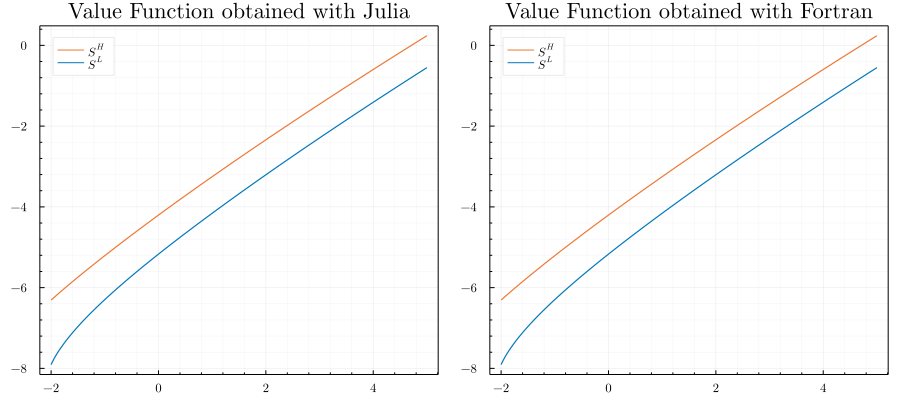

In [25]:
println("\t\tJulia function took: $(t_Julia_1);\t\t\t Fortran function took $(t_Fortran_1)" )
plot(p1, p2, size = (900, 400))

In [132]:
t_Fortran_1

0.2466721

In [8]:
x = cumsum(w[:,1] .+ w[:,2])
y = cumsum((w[:,1] .+ w[:,2]) .* prim.A_grid)
lorenz = unique([x/x[prim.nA] y/y[prim.nA]]; dims = 1)

526×2 Matrix{Float64}:
 0.0          -0.0
 0.000949087  -0.00146371
 0.000989482  -0.00152571
 0.00104614   -0.00161229
 0.00109133   -0.00168099
 0.00112628   -0.00173389
 0.00116667   -0.00179473
 0.00123713   -0.00190036
 0.001282     -0.0019673
 0.00132435   -0.00203018
 ⋮            
 0.999969      0.999931
 0.99997       0.999933
 0.999971      0.999935
 0.999972      0.999937
 0.999973      0.999939
 0.999973      0.999941
 0.999974      0.999943
 0.999975      0.999944
 1.0           1.0

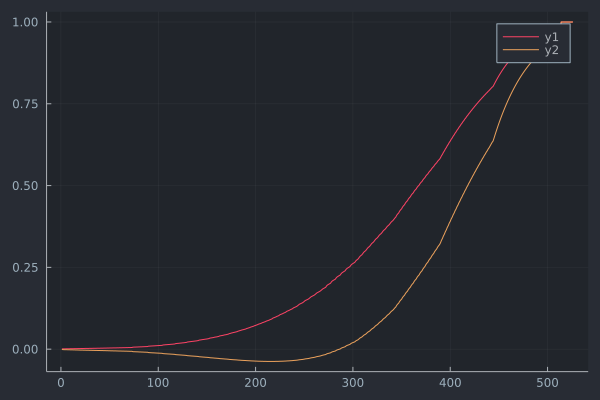

In [10]:
plot(lorenz)

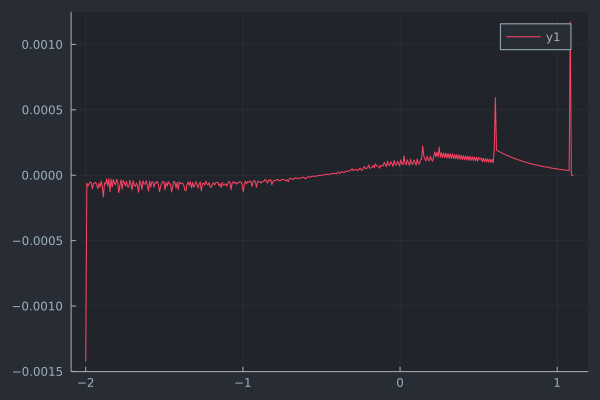

In [11]:
SS_WealthDistribution = sum(res.μ, dims = 2)
n_lorenz=1000
Lorenz=zeros(n_lorenz,2)
Lorenz[:,1]=collect(range(0,length=n_lorenz,1)) #First column is percent of population
i=1
for a_index=1:prim.nA
    if sum(SS_WealthDistribution[1:a_index])<=Lorenz[i,1]
        Lorenz[i,2]=Lorenz[i,2]+res.μ[a_index]*(prim.A_grid[a_index]+prim.S_vals[1]) +
        res.μ[prim.nA+a_index]*(prim.A_grid[a_index]+prim.S_vals[2]) #Second column is cumulative assets
    else
        while sum(SS_WealthDistribution[1:a_index])>Lorenz[i,1]
            i+=1
            Lorenz[i,2]=Lorenz[i-1,2]+0; #copy over the previous cumulative wealth
        end
    end
    Lorenz[i,2]=Lorenz[i,2]+res.μ[a_index]*(prim.A_grid[a_index]+prim.S_vals[1]) +
    res.μ[prim.nA+a_index]*(prim.A_grid[a_index]+prim.S_vals[2])
end

#######3
Lorenz

plot(Lorenz[:,1], Lorenz[:,2],  label = "Lorenz Curve", legend =:left)
plot!(Lorenz[:,1], Lorenz[:,1], label = "45 Degree")
# Plotting
cuttoff = findfirst(res.pol_func[:,1] .< prim.A_grid)
plot(prim.A_grid[1: cuttoff+50], res.μ[1:cuttoff+50, :])
plot(prim.A_grid, cumsum(res.μ, dims=1))

# cuttoff
cuttoff = findfirst(res.pol_func[:,1] .< prim.A_grid)

## Lorenz
w_e = res.μ[1:cuttoff,1] .* (prim.A_grid[1:cuttoff] .+ prim.S_vals[1] )
w_u = res.μ[1:cuttoff,2] .* (prim.A_grid[1:cuttoff] .+ prim.S_vals[2] )

plot(prim.A_grid[1:cuttoff], w_e)
plot(prim.A_grid[1:cuttoff], w_u)


## Question III

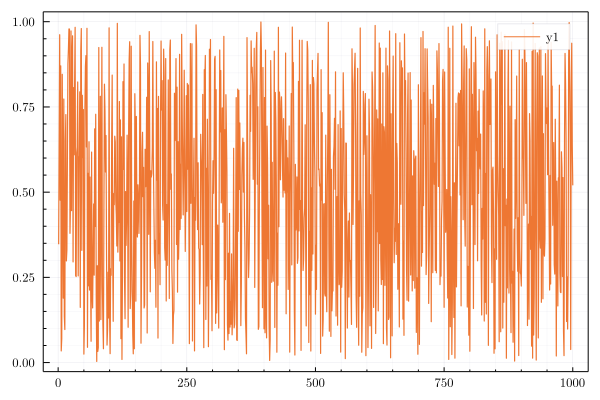

In [2]:
p1 = plot(rand(1000))

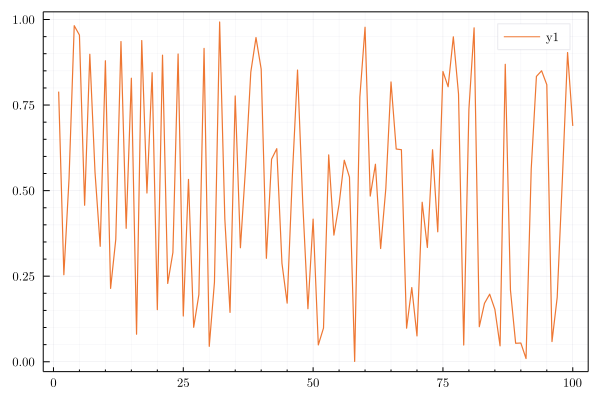

In [3]:
p2 = plot(rand(100))

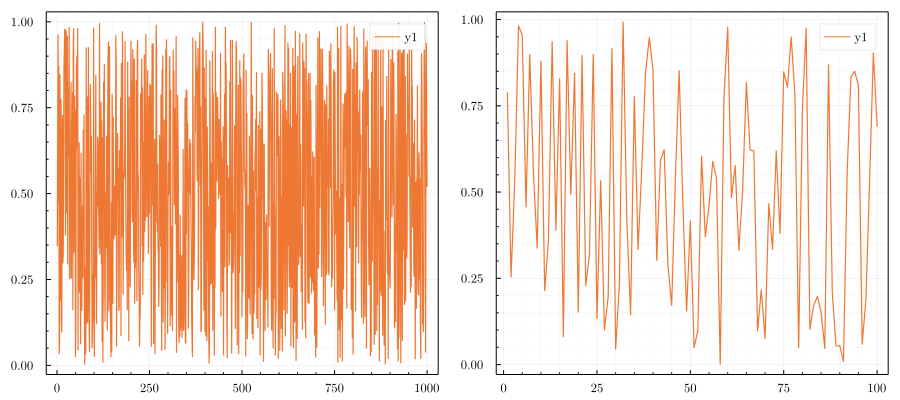

In [11]:
plot(p1,p2, size = (900, 400))